In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import joblib
import os

In [27]:
# Setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load data
data_path = "../data/DS_ElectricityLoad.csv"
df = pd.read_csv(data_path, parse_dates=["Date"])
df.sort_values("Date", inplace=True)

# Initial inspection
display(df.head())
display(df.info())
display(df.describe())


,Date,Load,Temperature,Cloudiness,Irradiation,PublicHolidays
0,2013-01-01 00:00:00,14859.1,4.4,4.0,0.2,1
1,2013-01-01 01:00:00,14116.1,4.7,4.7,0.2,1
2,2013-01-01 02:00:00,13400.8,4.7,4.7,0.2,1
3,2013-01-01 03:00:00,12883.6,4.7,4.7,0.2,1
4,2013-01-01 04:00:00,12717.3,4.4,4.2,0.2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16976 entries, 0 to 16975
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            16976 non-null  datetime64[ns]
 1   Load            16976 non-null  float64       
 2   Temperature     16976 non-null  float64       
 3   Cloudiness      16976 non-null  float64       
 4   Irradiation     16976 non-null  float64       
 5   PublicHolidays  16976 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 795.9 KB


None

,Date,Load,Temperature,Cloudiness,Irradiation,PublicHolidays
count,16976,16976.000000,16976.000000,16976.000000,16976.000000,16976.000000
mean,2013-12-20 15:30:00,18045.582410,9.882805,4.743962,0.597926,0.035344
min,2013-01-01 00:00:00,10494.000000,-14.000000,0.000000,0.100000,0.000000
25%,2013-06-26 19:45:00,15559.400000,3.600000,3.300000,0.300000,0.000000
50%,2013-12-20 15:30:00,18306.600000,10.500000,4.900000,0.600000,0.000000
75%,2014-06-15 11:15:00,20313.425000,15.900000,6.300000,0.900000,0.000000
max,2014-12-09 07:00:00,25459.000000,32.200000,8.000000,1.000000,1.000000
std,NaN,2981.372738,8.065015,1.951630,0.308994,0.184653


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1.1. Count missing values
missing_counts = df.isna().sum()
print("Missing / Null values per column:\n", missing_counts)

# 1.1.2. Percentage of missing values
missing_pct = (df.isna().mean() * 100).round(2)
print("\nPercentage missing:\n", missing_pct)

# 1.1.3. Plot missingness heatmap (if any missing values exist)
if missing_counts.any():
    plt.figure(figsize=(12, 4))
    sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title("Data Missingness Heatmap")
    plt.xlabel("Columns")
    plt.tight_layout()
    plt.savefig("../plots/missingness_heatmap.png")
    plt.show()
else:
    print("\nNo missing values detected.")


Missing / Null values per column:
 Date                  0
Load                  0
Temperature           0
Cloudiness            0
Irradiation           0
PublicHolidays        0
hour                  0
dayofweek             0
month                 0
is_weekend            0
hour_sin              0
hour_cos              0
dayofweek_sin         0
dayofweek_cos         0
lag_1                 0
lag_24                0
lag_168               0
temp_lag_1            0
temp_lag_24           0
irradiation_lag_1     0
irradiation_lag_24    0
load_roll_3h          0
load_roll_6h          0
load_roll_24h         0
temp_roll_6h          0
irr_roll_6h           0
temp_x_irradiation    0
weekend_temp          0
dtype: int64

Percentage missing:
 Date                  0.0
Load                  0.0
Temperature           0.0
Cloudiness            0.0
Irradiation           0.0
PublicHolidays        0.0
hour                  0.0
dayofweek             0.0
month                 0.0
is_weekend            0.

In [48]:
# 1.2.1. Data types and unique counts
print("Column types and non‐null counts:\n", df.info())

# 1.2.2. Unique values for categorical features
for col in ["PublicHolidays","is_weekend"]:
    if col in df.columns:
        print(f"\nUnique values in {col}: {df[col].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16808 entries, 0 to 16807
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                16808 non-null  datetime64[ns]
 1   Load                16808 non-null  float64       
 2   Temperature         16808 non-null  float64       
 3   Cloudiness          16808 non-null  float64       
 4   Irradiation         16808 non-null  float64       
 5   PublicHolidays      16808 non-null  int64         
 6   hour                16808 non-null  int32         
 7   dayofweek           16808 non-null  int32         
 8   month               16808 non-null  int32         
 9   is_weekend          16808 non-null  bool          
 10  hour_sin            16808 non-null  float64       
 11  hour_cos            16808 non-null  float64       
 12  dayofweek_sin       16808 non-null  float64       
 13  dayofweek_cos       16808 non-null  float64   

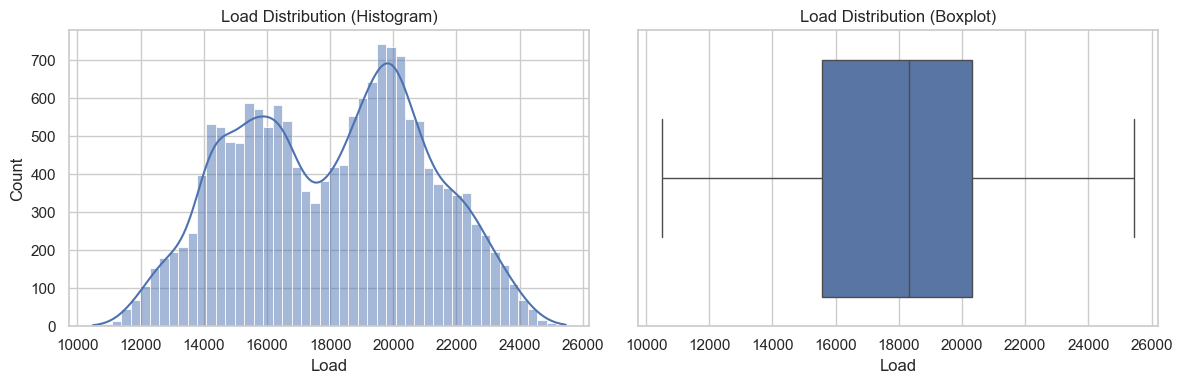

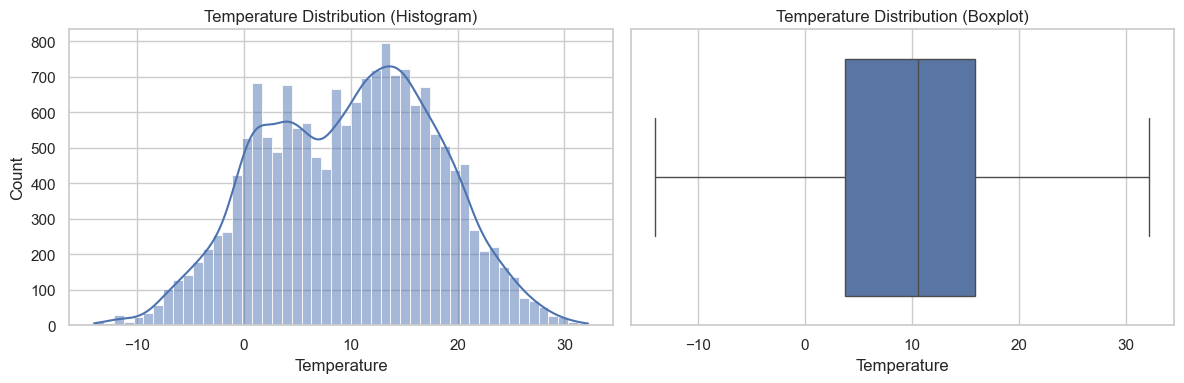

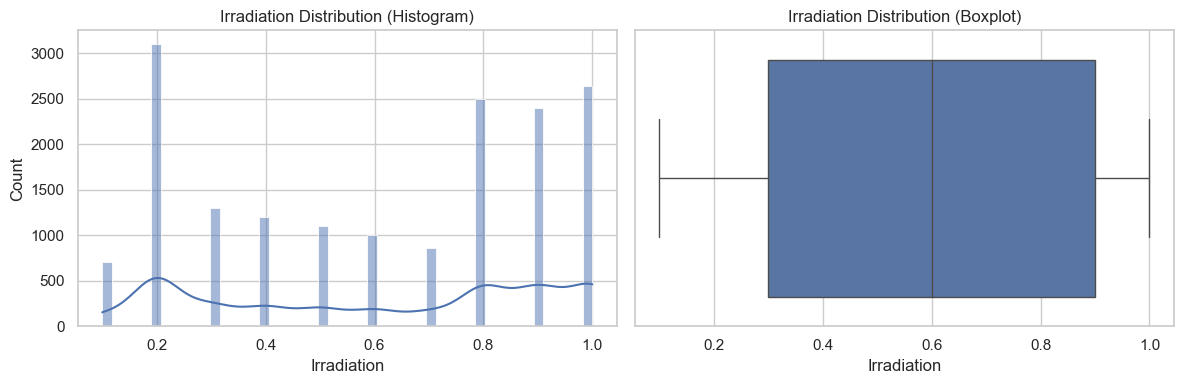

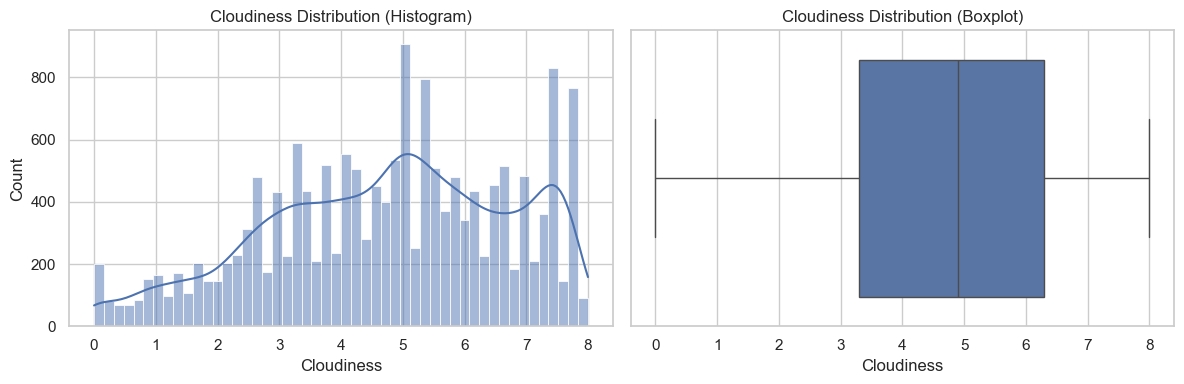

In [49]:
numeric_cols = ["Load", "Temperature", "Irradiation", "Cloudiness"]  # assume Cloudiness is numeric
for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f"{col} Distribution (Histogram)")
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"{col} Distribution (Boxplot)")
        
        plt.tight_layout()
        plt.savefig(f"../plots/{col}_dist_boxplot.png")
        plt.show()

/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/235026553.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_decomp = df_decomp.asfreq('H')


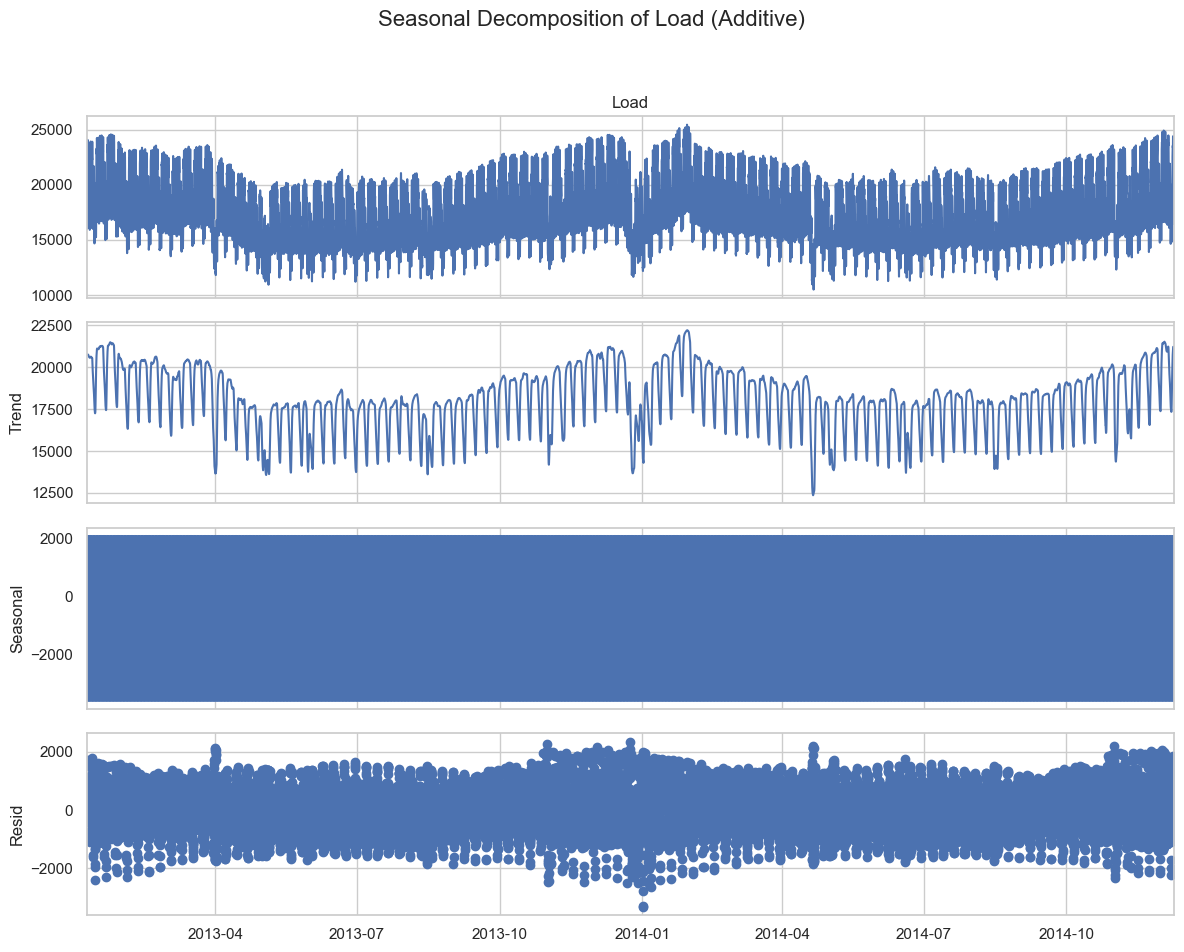

In [51]:
import statsmodels.api as sm

# 1.4.1. Set Date as index
df_decomp = df.set_index("Date")["Load"]

# 1.4.2. If any missing timestamps, re‐index to hourly and interpolate
df_decomp = df_decomp.asfreq('H')
if df_decomp.isna().any():
    df_decomp = df_decomp.interpolate(method='time')

# 1.4.3. Decompose: use a period of 24 for daily seasonality
decomposition = sm.tsa.seasonal_decompose(df_decomp, model="additive", period=24)

# 1.4.4. Plot the four components
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle("Seasonal Decomposition of Load (Additive)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../plots/load_decomposition.png")
plt.show()


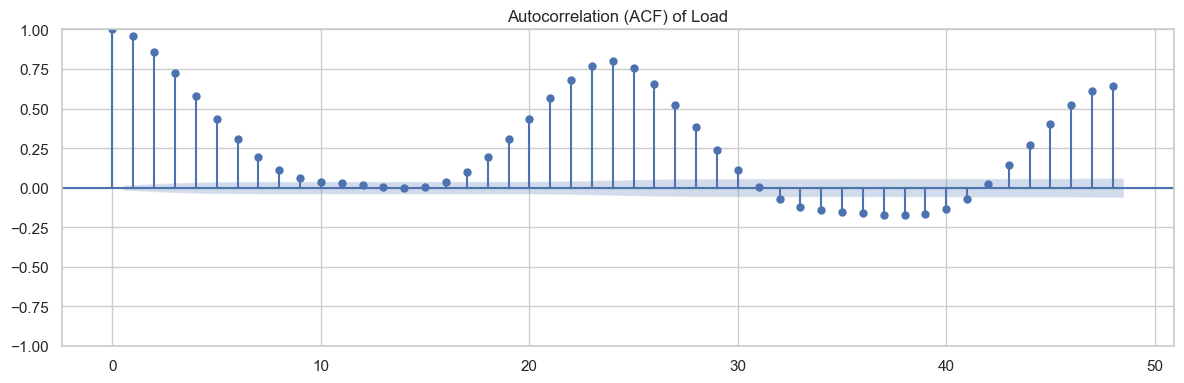

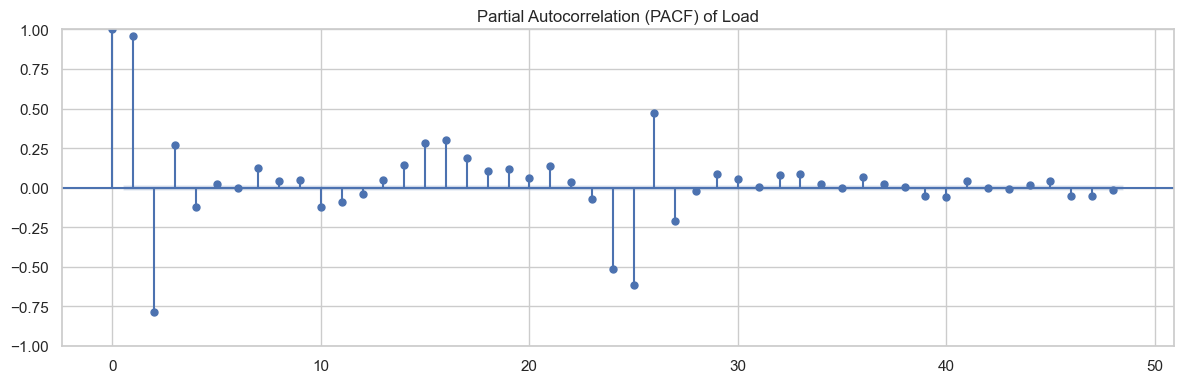

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plot_acf(df_decomp, lags=48, ax=plt.gca())
plt.title("Autocorrelation (ACF) of Load")
plt.tight_layout()
plt.savefig("../plots/load_acf.png")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(df_decomp, lags=48, ax=plt.gca(), method="ywm")
plt.title("Partial Autocorrelation (PACF) of Load")
plt.tight_layout()
plt.savefig("../plots/load_pacf.png")
plt.show()


/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/3637785039.py:10: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/3637785039.py:11: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig("../plots/rolling_corr_Cloudiness_load_temp.png")
/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/3637785039.py:11: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig("../plots/rolling_corr_Cloudiness_load_temp.png")
/Users/sandupamabalasuriya/IFS_project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sandupamabalasuriya/IFS_project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(

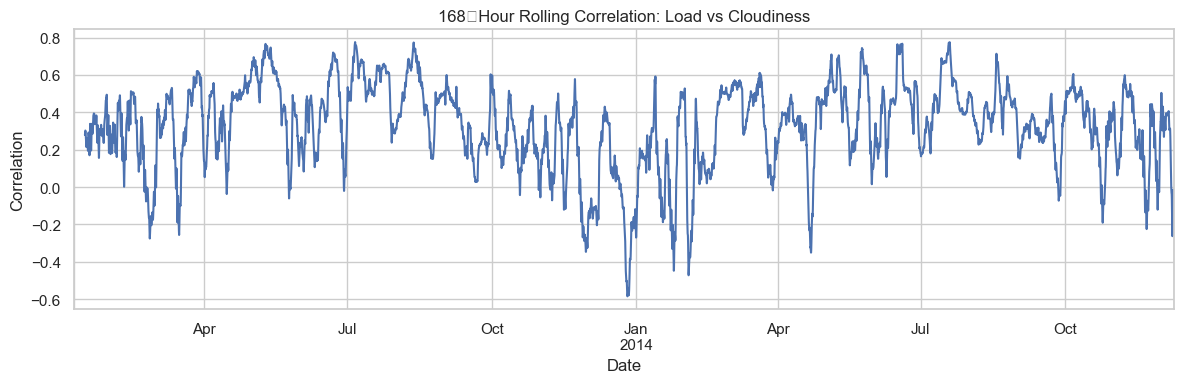

In [56]:
# 1.6.1. Compute rolling correlation between Load and Temperature with a 168‐hour window
if "Cloudiness" in df.columns:
    rolling_corr = df.set_index("Date")["Load"].rolling(window=168).corr(df.set_index("Date")["Temperature"])
    
    plt.figure(figsize=(12, 4))
    rolling_corr.plot()
    plt.title("168‐Hour Rolling Correlation: Load vs Cloudiness")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.tight_layout()
    plt.savefig("../plots/rolling_corr_Cloudiness_load_temp.png")
    plt.show()


In [28]:
import numpy as np
import pandas as pd

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # === Time-based cyclical features ===
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    # === Lag features (target & weather) ===
    df["lag_1"] = df["Load"].shift(1)
    df["lag_24"] = df["Load"].shift(24)
    df["lag_168"] = df["Load"].shift(168)

    if "Temperature" in df.columns:
        df["temp_lag_1"] = df["Temperature"].shift(1)
        df["temp_lag_24"] = df["Temperature"].shift(24)

    if "Irradiation" in df.columns:
        df["irradiation_lag_1"] = df["Irradiation"].shift(1)
        df["irradiation_lag_24"] = df["Irradiation"].shift(24)

    # === Rolling windows (Load) ===
    df["load_roll_3h"] = df["Load"].rolling(window=3).mean()
    df["load_roll_6h"] = df["Load"].rolling(window=6).mean()
    df["load_roll_24h"] = df["Load"].rolling(window=24).mean()

    # === Rolling (weather) ===
    if "Temperature" in df.columns:
        df["temp_roll_6h"] = df["Temperature"].rolling(window=6).mean()

    if "Irradiation" in df.columns:
        df["irr_roll_6h"] = df["Irradiation"].rolling(window=6).mean()

    # === Interaction features ===
    if "Temperature" in df.columns and "Irradiation" in df.columns:
        df["temp_x_irradiation"] = df["Temperature"] * df["Irradiation"]

    if "Temperature" in df.columns:
        df["weekend_temp"] = df["is_weekend"] * df["Temperature"]

    # === Drop rows with NaNs caused by shifting ===
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


In [29]:
# Feature Engineering
df["hour"] = df["Date"].dt.hour
df["dayofweek"] = df["Date"].dt.dayofweek
df["month"] = df["Date"].dt.month
df["is_weekend"] = df["dayofweek"] >= 5

df = engineer_features(df)
print(df.columns)
print(df.head())

Index(['Date', 'Load', 'Temperature', 'Cloudiness', 'Irradiation',
       'PublicHolidays', 'hour', 'dayofweek', 'month', 'is_weekend',
       'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'lag_1',
       'lag_24', 'lag_168', 'temp_lag_1', 'temp_lag_24', 'irradiation_lag_1',
       'irradiation_lag_24', 'load_roll_3h', 'load_roll_6h', 'load_roll_24h',
       'temp_roll_6h', 'irr_roll_6h', 'temp_x_irradiation', 'weekend_temp'],
      dtype='object')
                 Date     Load  Temperature  Cloudiness  Irradiation  \
0 2013-01-08 00:00:00  17031.9         -1.7         5.5          0.2   
1 2013-01-08 01:00:00  16253.0         -2.8         5.7          0.2   
2 2013-01-08 02:00:00  16007.0         -2.8         5.7          0.2   
3 2013-01-08 03:00:00  15993.1         -2.8         5.7          0.2   
4 2013-01-08 04:00:00  16274.6         -2.4         7.1          0.2   

   PublicHolidays  hour  dayofweek  month  is_weekend  ...  temp_lag_24  \
0               0     0    

/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/439090080.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df.set_index("Date")["Load"].asfreq("H")
/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/439090080.py:47: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()


Number of residual‐based anomalies: 17


/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/439090080.py:48: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig("../plots/residual_anomalies.png")
/Users/sandupamabalasuriya/IFS_project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


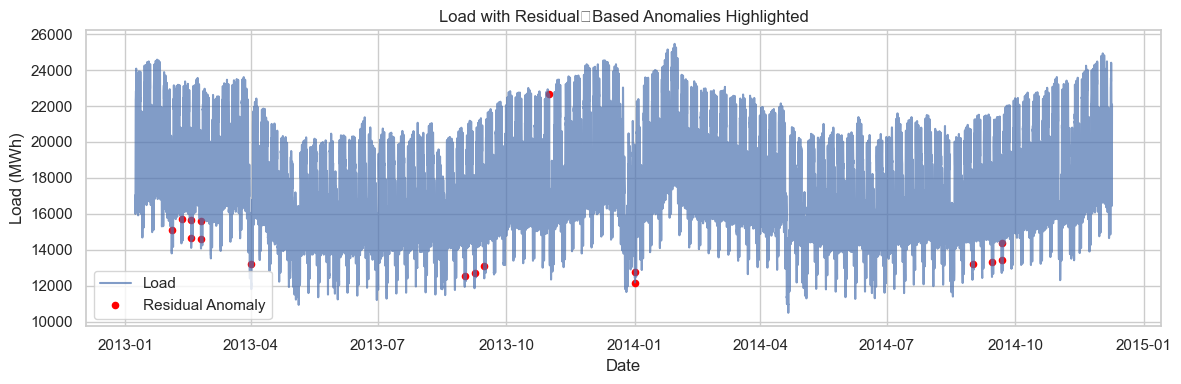

In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def detect_anomalies_by_residual(df: pd.DataFrame, resid_thresh: float = 3.0):
    """
    1. Use seasonal decomposition residuals to flag anomalies where
       |residual| > resid_thresh * rolling_std(residual, 168).
    2. Returns a DataFrame with an 'anomaly_residual' column (True/False).
    """
    df = df.copy()
    
    # 2.1.1. Prepare series
    ts = df.set_index("Date")["Load"].asfreq("H")
    ts_interpolated = ts.interpolate(method="time")
    
    # 2.1.2. Seasonal decomposition (daily period = 24)
    decomposition = sm.tsa.seasonal_decompose(ts_interpolated, model="additive", period=24)
    residual = decomposition.resid
    df["residual"] = residual.values  # align by index
    
    # 2.1.3. Rolling standard deviation of residual (one week = 168 hours)
    rolling_std = residual.rolling(window=168, min_periods=24).std()
    
    # 2.1.4. Mark anomalies where |residual| > resid_thresh * rolling_std
    df["anomaly_residual"] = False
    df.loc[
        (df["residual"].abs() > resid_thresh * rolling_std.values), 
        "anomaly_residual"
    ] = True
    
    return df

# ---------- Usage ----------
df_with_resid_anom = detect_anomalies_by_residual(df, resid_thresh=3.0)
print("Number of residual‐based anomalies:", df_with_resid_anom["anomaly_residual"].sum())

# Plot anomalies on the time series
plt.figure(figsize=(12, 4))
plt.plot(df_with_resid_anom["Date"], df_with_resid_anom["Load"], label="Load", alpha=0.7)
anomalies = df_with_resid_anom[df_with_resid_anom["anomaly_residual"]]
plt.scatter(anomalies["Date"], anomalies["Load"], color="red", label="Residual Anomaly", s=20)
plt.title("Load with Residual‐Based Anomalies Highlighted")
plt.xlabel("Date")
plt.ylabel("Load (MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/residual_anomalies.png")
plt.show()


Number of IsolationForest anomalies: 169


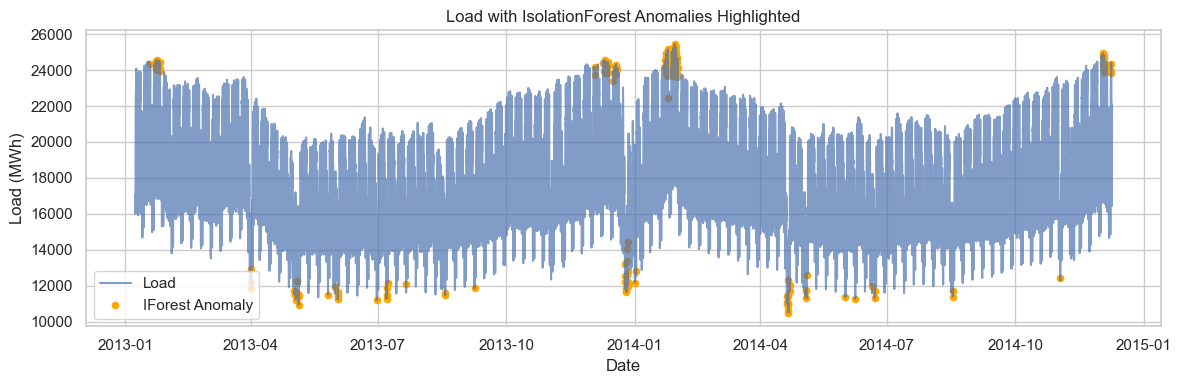

In [58]:
from sklearn.ensemble import IsolationForest

def detect_anomalies_isolationforest(df: pd.DataFrame, contamination: float = 0.01):
    """
    1. Runs an IsolationForest on selected numeric features (including lags & rolling statistics).
    2. Returns the DataFrame with a boolean column 'anomaly_iforest'.
    """
    df = df.copy()
    
    # 2.2.1. Select columns for anomaly detection
    #    Include: Load, Temperature, Cloudiness, Irradiation, lag_1, lag_24, load_roll_24h, etc.
    feature_cols = []
    for col in ["Load", "Temperature", "Cloudiness", "Irradiation",
                "lag_1", "lag_24", "lag_168", "load_roll_3h", "load_roll_6h", "load_roll_24h"]:
        if col in df.columns:
            feature_cols.append(col)
    
    X = df[feature_cols].dropna()
    
    # 2.2.2. Fit IsolationForest
    iso = IsolationForest(
        n_estimators=100,
        max_samples="auto",
        contamination=contamination,
        random_state=42
    )
    iso.fit(X)
    
    # 2.2.3. Predict anomalies: -1 = anomaly, +1 = normal
    df["anomaly_iforest"] = np.nan
    df.loc[X.index, "anomaly_iforest"] = iso.predict(X)
    
    # 2.2.4. Convert anomaly label to boolean (True if anomaly)
    df["anomaly_iforest"] = df["anomaly_iforest"].map({1: False, -1: True})
    df.reset_index(drop=True, inplace=True)
    
    return df

# ---------- Usage ----------
df_with_iforest = detect_anomalies_isolationforest(df_with_resid_anom, contamination=0.01)
print("Number of IsolationForest anomalies:", df_with_iforest["anomaly_iforest"].sum())

# Plot IsolationForest anomalies on Load
plt.figure(figsize=(12, 4))
plt.plot(df_with_iforest["Date"], df_with_iforest["Load"], label="Load", alpha=0.7)
iforest_anoms = df_with_iforest[df_with_iforest["anomaly_iforest"]]
plt.scatter(iforest_anoms["Date"], iforest_anoms["Load"], color="orange", label="IForest Anomaly", s=20)
plt.title("Load with IsolationForest Anomalies Highlighted")
plt.xlabel("Date")
plt.ylabel("Load (MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/iforest_anomalies.png")
plt.show()


Total combined anomalies: 185


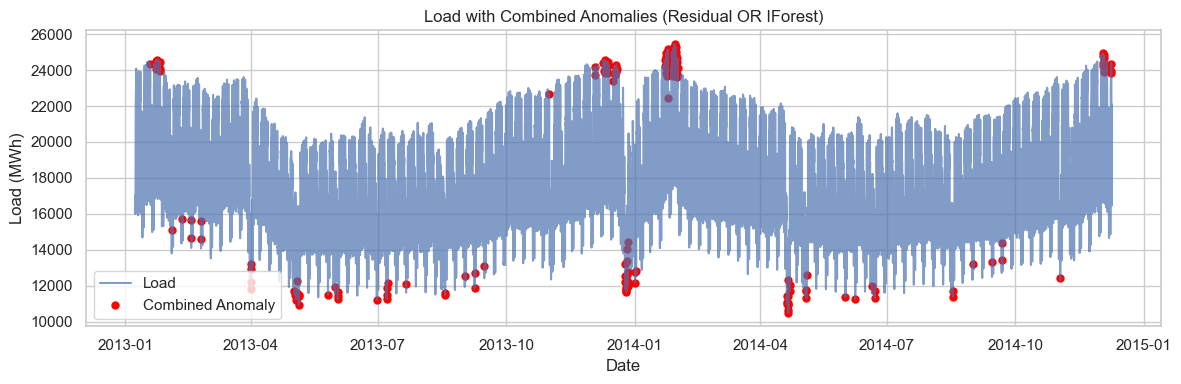

In [59]:
# 2.3.1. Combine flags: anomaly if either method flags
df_combined = df_with_iforest.copy()
df_combined["anomaly_combined"] = (
    df_combined["anomaly_residual"].fillna(False) | df_combined["anomaly_iforest"].fillna(False)
)

print("Total combined anomalies:", df_combined["anomaly_combined"].sum())

# Plot combined anomalies
plt.figure(figsize=(12, 4))
plt.plot(df_combined["Date"], df_combined["Load"], label="Load", alpha=0.7)
combo_anoms = df_combined[df_combined["anomaly_combined"]]
plt.scatter(combo_anoms["Date"], combo_anoms["Load"], color="red", label="Combined Anomaly", s=25)
plt.title("Load with Combined Anomalies (Residual OR IForest)")
plt.xlabel("Date")
plt.ylabel("Load (MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/combined_anomalies.png")
plt.show()


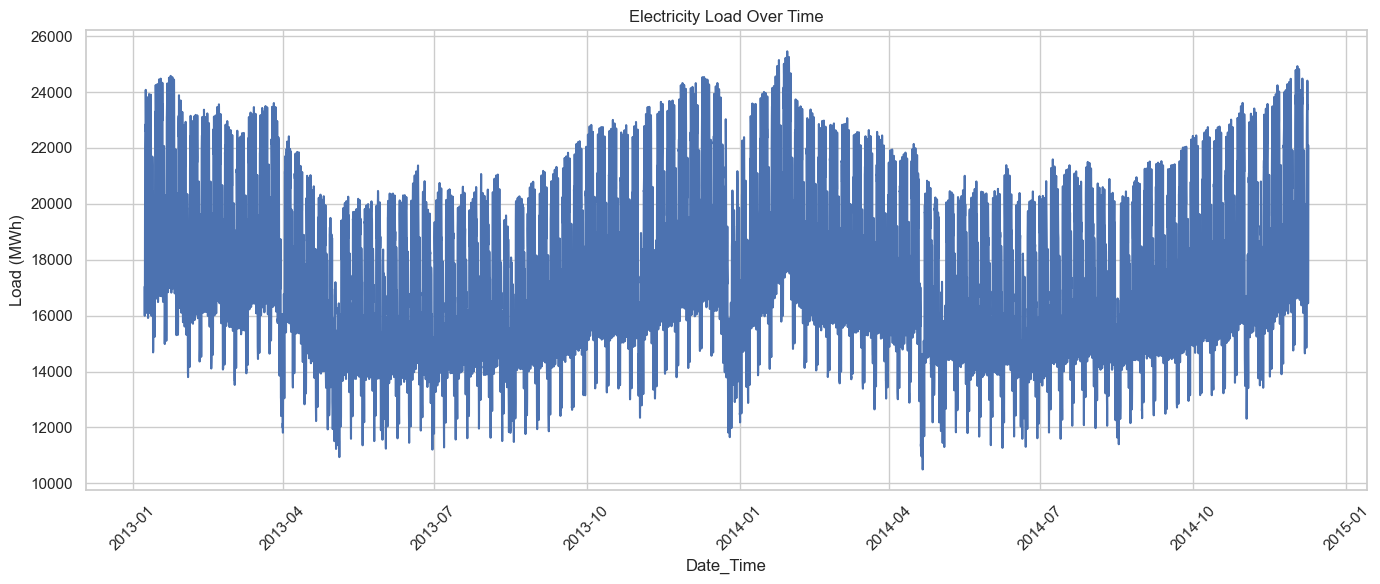

In [30]:


# Time-series Plot
plt.figure()
sns.lineplot(data=df, x="Date", y="Load")
plt.title("Electricity Load Over Time")
plt.xlabel("Date_Time")
plt.ylabel("Load (MWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../plots/load_timeseries_plot.png")
plt.show()

/var/folders/r7/zd1rrwgd353g8m53hfgj65g40000gn/T/ipykernel_5208/4042379795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="viridis")


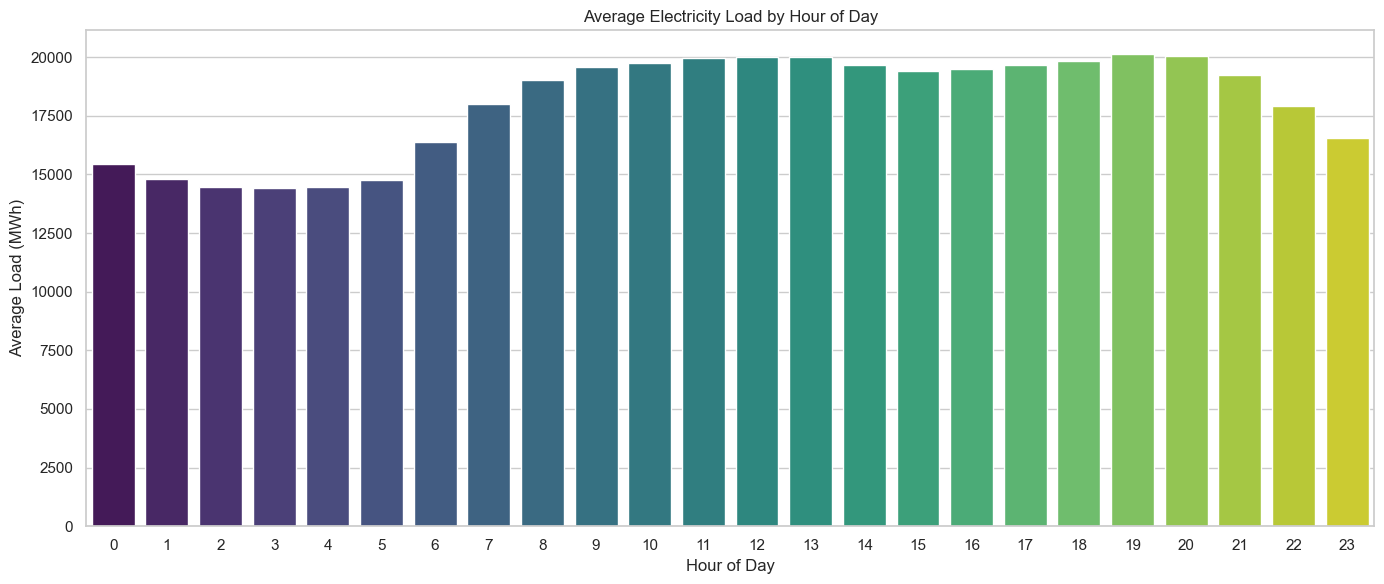

In [31]:
plt.figure()
hourly_avg = df.groupby("hour")["Load"].mean()
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="viridis")
plt.title("Average Electricity Load by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load (MWh)")
plt.tight_layout()
plt.savefig("../plots/hourly_peak_consumption.png")
plt.show()

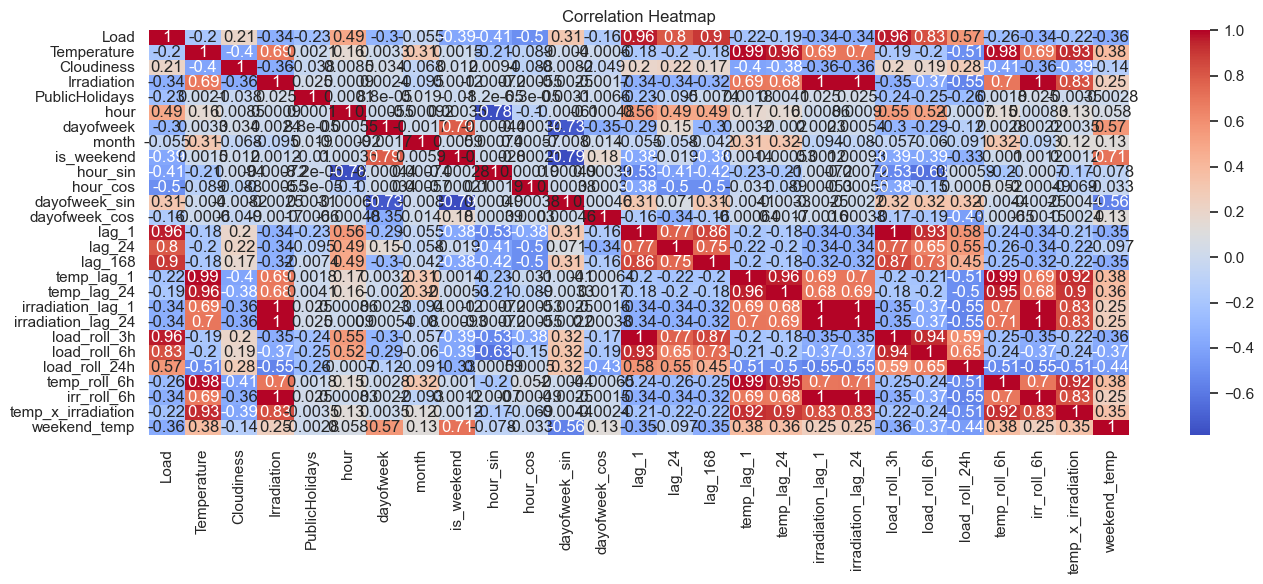

In [32]:
# Correlation Heatmap
plt.figure()
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("../plots/correlation_heatmap.png")
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": round(mae, 2), "RMSE": round(rmse, 2), "MAPE": round(mape, 2)}


In [38]:
from prophet import Prophet
# from src.evaluate import evaluate_forecast

def train_and_predict_prophet(df, forecast_horizon=48):
    df = df.copy()
    df.rename(columns={"Date": "ds", "Load": "y"}, inplace=True)
    train = df[:-forecast_horizon]
    test = df[-forecast_horizon:]

    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=forecast_horizon, freq="H")
    forecast = model.predict(future)

    forecast_values = forecast["yhat"].tail(forecast_horizon).values
    actual_values = test["y"].values
    metrics = evaluate_forecast(actual_values, forecast_values)
    # Save trained model
    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, "../models/prophet_model.pkl")
    print("Model and forecast saved.")

    return forecast.tail(forecast_horizon)[["ds", "yhat"]], test[["ds", "y"]], metrics


In [39]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense
# from src.evaluate import evaluate_forecast

def create_lagged_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

def train_and_predict_lstm(df, forecast_horizon=48, lookback=24):
    df = df.copy()
    df = df.dropna()
    
    values = df["Load"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(values)

    X, y = create_lagged_sequences(values_scaled, lookback)

    # Split train/test
    split_point = len(X) - forecast_horizon
    X_train, y_train = X[:split_point], y[:split_point]
    X_test, y_test = X[split_point:], y[split_point:]

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    metrics = evaluate_forecast(y_true, y_pred)

    # Save trained model
    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, "../models/lstm_model.pkl")
    print("Model and forecast saved.")
    return y_pred, y_true, metrics


In [41]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
# from src.evaluate import evaluate_forecast

def train_and_predict_xgboost(df, forecast_horizon=48):
    df = df.copy()
    
    # Remove target leakage
    df = df.dropna()

    feature_cols = [col for col in df.columns if col not in ["Date", "Load"]]
    target_col = "Load"

    X_train = df.iloc[:-forecast_horizon][feature_cols]
    y_train = df.iloc[:-forecast_horizon][target_col]
    X_test = df.iloc[-forecast_horizon:][feature_cols]
    y_test = df.iloc[-forecast_horizon:][target_col]

    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    metrics = evaluate_forecast(y_test, preds)

        # Save trained model
    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, "../models/xgboost_model.pkl")
    print("Model and forecast saved.")

    return preds, y_test.reset_index(drop=True), metrics


In [42]:
import pandas as pd
# from src.arima_model import train_and_predict_arima
# from src.prophet_model import train_and_predict_prophet
# from src.xgboost_model import train_and_predict_xgboost
# from src.lstm_model import train_and_predict_lstm



print("\n--- Prophet ---")
pred_prophet, actual_prophet, metrics_prophet = train_and_predict_prophet(df)
print(metrics_prophet)

print("\n--- XGBoost ---")
pred_xgb, actual_xgb, metrics_xgb = train_and_predict_xgboost(df)
print(metrics_xgb)

print("\n--- LSTM ---")
pred_lstm, actual_lstm, metrics_lstm = train_and_predict_lstm(df)
print(metrics_lstm)




--- Prophet ---


09:10:23 - cmdstanpy - INFO - Chain [1] start processing
09:10:27 - cmdstanpy - INFO - Chain [1] done processing
/Users/sandupamabalasuriya/IFS_project/.venv/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Model and forecast saved.
{'MAE': 956.14, 'RMSE': 1281.69, 'MAPE': 4.53}

--- XGBoost ---
Model and forecast saved.
{'MAE': 156.95, 'RMSE': 197.41, 'MAPE': 0.8}

--- LSTM ---


/Users/sandupamabalasuriya/IFS_project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step
Model and forecast saved.
{'MAE': 274.4, 'RMSE': 436.78, 'MAPE': 1.41}


In [ ]:
# Forecast 48 hours ahead
# future = model.make_future_dataframe(periods=48, freq='H')
# forecast = model.predict(future)

future_valid = pd.DataFrame({"ds": valid_actual["ds"]})
forecast_valid = model.predict(future_valid)

In [ ]:
# Plot forecast
fig = model.plot(forecast_valid)
plt.tight_layout()
plt.savefig("../plots/forecast_plot.png")
plt.show()

In [ ]:


# Save trained model
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/prophet_model.pkl")
print("Model and forecast saved.")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge predictions with actuals
eval_df = valid_actual.merge(forecast_valid[["ds", "yhat"]], on="ds", how="left")
eval_df.dropna(inplace=True)
print(eval_df.head(10))

# Metrics
mae = mean_absolute_error(eval_df["y"], eval_df["yhat"])
rmse = np.sqrt(mean_squared_error(eval_df["y"], eval_df["yhat"]))
mape = np.mean(np.abs((eval_df["y"] - eval_df["yhat"]) / eval_df["y"])) * 100

print("Validation Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
